In [1]:
import cv2,os
import time
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from skimage import io, transform
from skimage.io import imread, imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [115]:
# Data(x)
untreaded_train=np.load("../Classification/results2022/untreaded_train.npy",allow_pickle=True)
# untreaded_train=np.load("../Classification/results2022/untreaded_train_all.npy",allow_pickle=True)[:10000]
VPAtreaded_train=np.load("../Classification/results2022/VPAtreaded_train.npy",allow_pickle=True)
untreaded_test=np.load("../Classification/results2022/untreaded_test.npy",allow_pickle=True)
VPAtreaded_test=np.load("../Classification/results2022/VPAtreaded_test.npy",allow_pickle=True)

print("untreaded_train.shape:", untreaded_train.shape)
print("VPAtreaded_train.shape:", VPAtreaded_train.shape)
print("untreaded_test.shape:", untreaded_test.shape)
print("VPAtreaded_test.shape:", VPAtreaded_test.shape)

# Label(y)
y_untreaded_train = np.zeros(len(untreaded_train), dtype=np.int32)
y_VPAtreaded_train = np.ones(len(VPAtreaded_train), dtype=np.int32)

y_untreaded_test = np.zeros(len(untreaded_test), dtype=np.int32)
y_VPAtreaded_test = np.ones(len(VPAtreaded_test), dtype=np.int32)

# concatenate x and y
X_train, X_test = np.concatenate((untreaded_train, VPAtreaded_train), axis = 0), np.concatenate((untreaded_test, VPAtreaded_test), axis = 0)
y_train, y_test = np.concatenate((y_untreaded_train, y_VPAtreaded_train), axis = 0), np.concatenate((y_untreaded_test, y_VPAtreaded_test), axis = 0)

untreaded_train.shape: (3000, 100, 100, 3)
VPAtreaded_train.shape: (3000, 100, 100, 3)
untreaded_test.shape: (210, 100, 100, 3)
VPAtreaded_test.shape: (210, 100, 100, 3)


# 2. Data processing

In [177]:
# cell 3C: (self.transform(self.x[idx])>0).float()
# cell 1C: ((self.transform(self.x[idx])>0).float()[0]).unsqueeze(0).float()
# ones 3C: torch.ones(3,100,100).float()
# ones 1C: torch.ones(1,100,100).float()

class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x):
        self.x = x
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), self.transform(self.x[idx][:,:,0])

train_data = cell_dataset(X_train)
val_data = cell_dataset(X_test)

batch_size = 32
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

image:  torch.Size([3, 100, 100])
mask:  torch.Size([1, 100, 100])


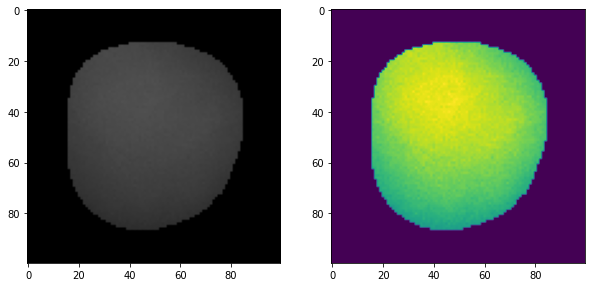

In [178]:
image, mask = train_data[0]
print("image: ",image.shape)
# print(torch.amax(image).item(),torch.amin(image).item())
print("mask: ",mask.shape)
# print(torch.amax(mask).item(),torch.amin(mask).item())

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0))

# 3. Build model 

## 3.1 UNet

In [179]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)
    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
#         self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    def forward(self, x, n):
#         x = self.up_sample(x)
        x = F.interpolate(x, size=[n,n], mode='nearest-exact')
        x = self.double_conv(x)
        return x
    
class UpBlock(nn.Module):
    def __init__(self):
        super(UpBlock, self).__init__()
        self.up_conv4 = Up(128, 64)
        self.up_conv3 = Up(64, 32)
        self.up_conv2 = Up(32, 16)
        self.up_conv1 = Up(16, 3)
        self.output = nn.Conv2d(3,1,kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.up_conv4(x,25)
        x = self.up_conv3(x,50)
        x = self.up_conv2(x,75)
        x = self.up_conv1(x,100)
        x = self.output(x)
        x = x/torch.amax(x)
        x = self.relu(x)
        return x

In [180]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 16)
        self.down_conv2 = DownBlock(16, 32)
        self.down_conv3 = DownBlock(32, 64)
        self.down_conv4 = DownBlock(64, 128)
        # Bottleneck
        self.double_conv = DoubleConv(128, 128)
        # Upsampling Path
        self.Upblock = UpBlock()
        
    def forward(self, input_image):
        x = self.down_conv1(input_image)
        x = self.down_conv2(x)
        x = self.down_conv3(x)
        x = self.down_conv4(x)
        x = F.interpolate(x, size=[17,17], mode='nearest-exact')
        x = self.double_conv(x)
        x = self.Upblock(x)
        return x

torch.Size([1, 1, 100, 100])


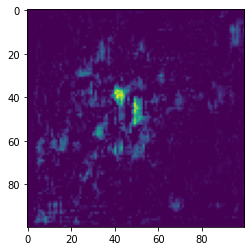

In [185]:
model = UNet().to(device)
# model_weight_unet2018bowl = torch.load('../Segmentation/qsub_pytorch/qsub220614/pytorch_unet_2018bowl_30.pt')
# model.load_state_dict(torch.load("UNet_one_1C_weight.pkl"))
ngpu = 1
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

test_input = train_data[i][0].unsqueeze(0).to(device)
y = model(test_input)
print(y.size())
plt.imshow(y[0].detach().cpu().permute(1,2,0))

## 3.2 Param setting

In [186]:
def calculate_iou(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou


def calculate_iou_batch(y_pred,y):
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(calculate_iou(pred, label))
    iou = np.nanmean(ious)
    return iou   

In [187]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                           
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final 

## 3.3 Train model

In [188]:
learning_rate = 3e-7
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = DiceBCELoss()
epochs = 10
train_loss_history,val_loss_history = [],[]
train_iou_history,val_iou_history = [],[]

In [196]:
def train(model, train_loader):
    model.train()
    train_loss, train_score, target_count = 0, 0, 0
    
    for images, masks in dataloader_train:
        images = images.to(device)
        masks  = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        train_loss += loss.item()
        train_score += score
        target_count += masks.shape[0]
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/target_count, train_score / target_count

def validate(model,val_loader):
    model.eval()
    val_loss, val_score, target_count = 0, 0, 0
    for images, masks in dataloader_valid:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        val_loss += loss.item()
        val_score += score
        target_count += masks.shape[0]

    return val_loss/target_count, val_score / target_count

In [197]:
for epoch in range(epochs):
    train_loss, train_score = train(model, dataloader_train)
    val_loss, val_score = validate(model, dataloader_valid)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_iou_history.append(train_score)
    val_iou_history.append(val_score)
    print('EPOCH: {}, Train [Loss: {:.6f}, Score: {:.6f}], Valid [Loss: {:.6f}, Score: {:.6f}]'
          .format(epoch,train_loss,train_score,val_loss,val_score))

EPOCH: 0, Train [Loss: 0.023757, Score: 0.003008], Valid [Loss: 0.025171, Score: 0.003317]
EPOCH: 1, Train [Loss: 0.023755, Score: 0.003011], Valid [Loss: 0.025181, Score: 0.003312]
EPOCH: 2, Train [Loss: 0.023753, Score: 0.003015], Valid [Loss: 0.025185, Score: 0.003307]
EPOCH: 3, Train [Loss: 0.023748, Score: 0.003019], Valid [Loss: 0.025147, Score: 0.003353]
EPOCH: 4, Train [Loss: 0.023746, Score: 0.003023], Valid [Loss: 0.025186, Score: 0.003309]
EPOCH: 5, Train [Loss: 0.023743, Score: 0.003027], Valid [Loss: 0.025120, Score: 0.003388]
EPOCH: 6, Train [Loss: 0.023742, Score: 0.003030], Valid [Loss: 0.025181, Score: 0.003316]
EPOCH: 7, Train [Loss: 0.023737, Score: 0.003035], Valid [Loss: 0.025157, Score: 0.003347]
EPOCH: 8, Train [Loss: 0.023736, Score: 0.003039], Valid [Loss: 0.025051, Score: 0.003473]
EPOCH: 9, Train [Loss: 0.023734, Score: 0.003041], Valid [Loss: 0.025189, Score: 0.003306]


In [144]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.Upblock.state_dict(),"Upblock_weight_1Cone_nearest.pkl")

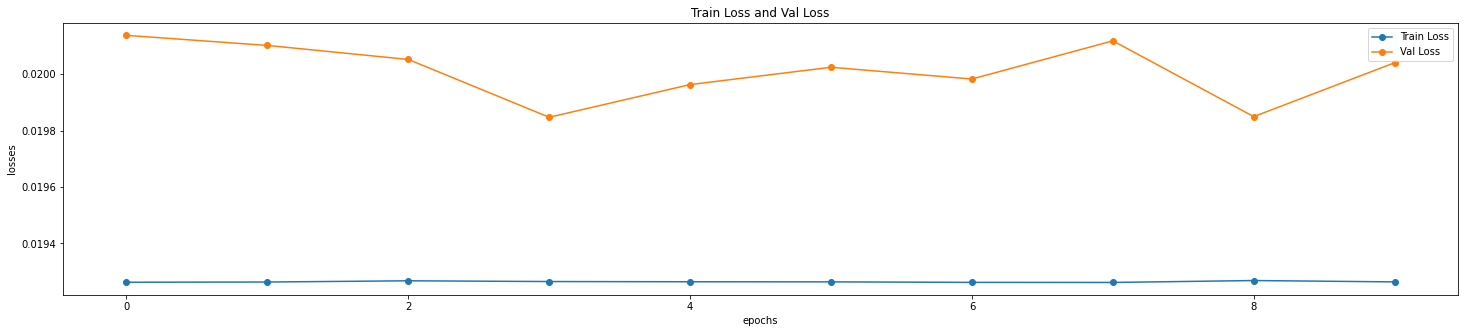

In [74]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epochs')
plt.ylabel('losses')
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Loss','Val Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

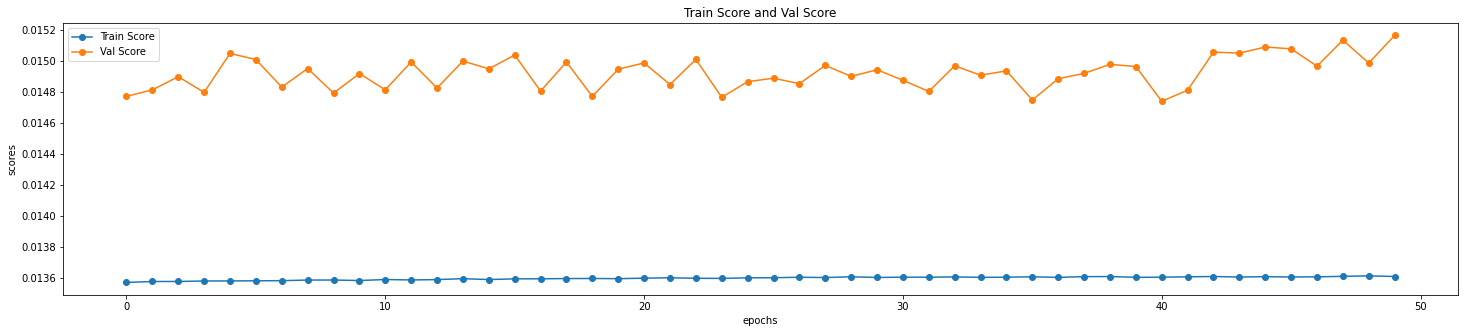

In [64]:
plt.figure(figsize=(25,5))
plt.plot(train_iou_history,'-o')
plt.plot(val_iou_history,'-o')
plt.xlabel('epochs')
plt.ylabel('scores')
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Score','Val Score'])
plt.title('Train Score and Val Score')
plt.show()

# 4. Test model

In [43]:
model.load_state_dict(torch.load("UNet_cell_3C_weight.pkl"))

<All keys matched successfully>

In [194]:
imgs,masks = next(iter(dataloader_train))
print(imgs.shape,masks.shape)

torch.Size([32, 3, 100, 100]) torch.Size([32, 1, 100, 100])


images: torch.Size([1, 3, 100, 100])
masks: torch.Size([32, 1, 100, 100])
predict_masks: torch.Size([1, 1, 100, 100])


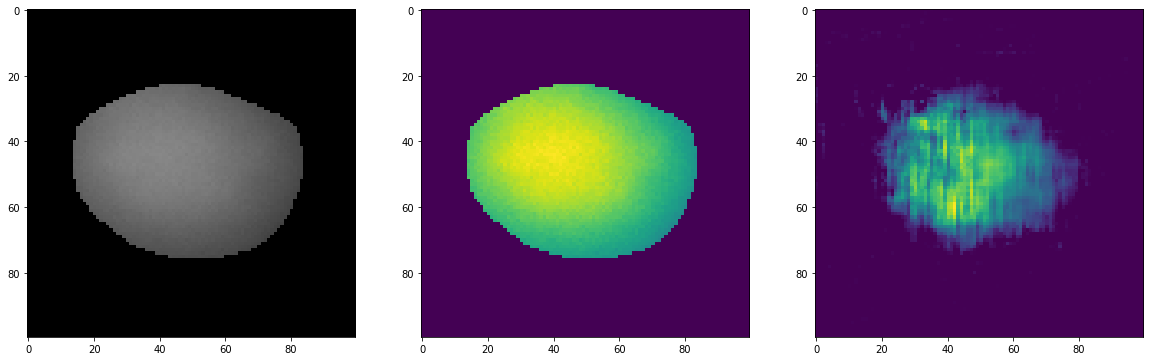

In [198]:
n = 0
images = imgs[n:n+1].to(device)
predict_masks = model(images)
print(f"images: {images.shape}")
print(f"masks: {masks.shape}")
print(f"predict_masks: {predict_masks.shape}")

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(images[0].permute(1, 2, 0).cpu())
plt.subplot(1,3,2)
plt.imshow(masks[n].permute(1, 2, 0).cpu())
plt.subplot(1,3,3)
plt.imshow(predict_masks[0].permute(1, 2, 0).detach().cpu().numpy())